In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="AlexNet"

dataset_name="caltech101"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")


Model: AlexNet with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55, 'lam

In [2]:
class AlexNet(nn.Module):

    def __init__(self) -> None:
        super(AlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def stn(self, x):    
        xs = self.localization(x)
        xs = xs.view(xs.shape[0], xs.shape[1]*xs.shape[2]*xs.shape[3])
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #x = self.stn(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [3]:

model = AlexNet()
model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)

#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, 224, 224)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.AlexNet'>. Treat it as zero Macs and zero Params.


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


The model requires: 0.7110 GFLOPS

torch.Size([20, 3, 224, 224])
torch.Size([20, 101])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2

In [6]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.0f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.0f}%)'.format(
        correct, len(test_loader.dataset),
        100.00 * correct / len(test_loader.dataset)))
    return 100.00 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [7]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//AlexNet20211221142009
grandstore_string
grandstore/caltech101_AlexNet20211221142009.pkl


In [8]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.2f}'.format(training_accuracy))
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [9]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=200,
                    minepoch=120,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.35                  
                   )

Running epoch: 1


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 29.50
Training Loss: 4094337.483957 	Validation Loss: 4145.420198

Running epoch: 2


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 32.00
Training Loss: 3336827.189633 	Validation Loss: 3811.892443

Running epoch: 3


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 36.50
Training Loss: 3080247.613173 	Validation Loss: 3552.730885

Running epoch: 4


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 38.75
Training Loss: 2804518.263435 	Validation Loss: 3348.691111

Running epoch: 5


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.33
Training Loss: 2570291.680607 	Validation Loss: 3136.276829

Running epoch: 6


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 43.83
Training Loss: 2428090.260127 	Validation Loss: 3038.173943

Running epoch: 7


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 46.83
Training Loss: 2221334.697502 	Validation Loss: 2939.108605

Running epoch: 8


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 44.75
Training Loss: 2074799.203641 	Validation Loss: 2980.213478

Running epoch: 9


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.25
Training Loss: 1862920.581315 	Validation Loss: 2822.929773

Running epoch: 10


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 1687258.536768 	Validation Loss: 2841.290698

Running epoch: 11


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.42
Training Loss: 1502302.382935 	Validation Loss: 3019.306273

Running epoch: 12


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 1377499.465230 	Validation Loss: 3005.350138

Running epoch: 13


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.50
Training Loss: 1272777.506138 	Validation Loss: 2891.579584

Running epoch: 14


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 47.75
Training Loss: 1091890.263939 	Validation Loss: 3084.704745

Running epoch: 15


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.92
Training Loss: 1064879.805028 	Validation Loss: 3008.829228

Running epoch: 16


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.33
Training Loss: 906560.703570 	Validation Loss: 3135.683696

Running epoch: 17


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 882398.860100 	Validation Loss: 3197.701004

Running epoch: 18


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.42
Training Loss: 733321.723039 	Validation Loss: 3511.642761

Running epoch: 19


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 720085.697226 	Validation Loss: 3549.272029

Running epoch: 20


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 639796.334412 	Validation Loss: 3390.495360

Running epoch: 21


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 589777.705828 	Validation Loss: 3649.242003

Running epoch: 22


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 605643.328698 	Validation Loss: 3728.053181

Running epoch: 23


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.25
Training Loss: 504082.167229 	Validation Loss: 3884.932239

Running epoch: 24


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.42
Training Loss: 524118.917493 	Validation Loss: 3743.532369

Running epoch: 25


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 619350.717670 	Validation Loss: 3788.163443

Running epoch: 26


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 477682.035695 	Validation Loss: 3634.474707

Running epoch: 27


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.42
Training Loss: 498300.782178 	Validation Loss: 4160.940225

Running epoch: 28


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 51.00
Training Loss: 496834.576737 	Validation Loss: 4154.356055

Running epoch: 29


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 449013.468819 	Validation Loss: 4100.957128

Running epoch: 30


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.58
Training Loss: 461405.007775 	Validation Loss: 4189.368157

Running epoch: 31


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.17
Training Loss: 426356.683496 	Validation Loss: 4234.187913

Running epoch: 32


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.08
Training Loss: 559816.769273 	Validation Loss: 4530.129361

Running epoch: 33


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 498750.560059 	Validation Loss: 4044.872537

Running epoch: 34


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.17
Training Loss: 532760.455850 	Validation Loss: 4517.886417

Running epoch: 35


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 451734.472739 	Validation Loss: 4603.588505

Running epoch: 36


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.58
Training Loss: 411287.570541 	Validation Loss: 4316.821191

Running epoch: 37


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 421515.987619 	Validation Loss: 4414.973173

Running epoch: 38


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.83
Training Loss: 393631.577893 	Validation Loss: 4911.242018

Running epoch: 39


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.08
Training Loss: 442961.335272 	Validation Loss: 4273.813844

Running epoch: 40


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 867250.761502 	Validation Loss: 3958.648572

Running epoch: 41


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 378782.312249 	Validation Loss: 4291.312668

Running epoch: 42


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 365754.996773 	Validation Loss: 4854.439733

Running epoch: 43


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.67
Training Loss: 507955.480185 	Validation Loss: 4775.116723

Running epoch: 44


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 397282.306007 	Validation Loss: 4564.845722

Running epoch: 45


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 391378.019004 	Validation Loss: 4338.994641

Running epoch: 46


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.67
Training Loss: 418137.628166 	Validation Loss: 4595.930128

Running epoch: 47


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 354961.535955 	Validation Loss: 5186.223993

Running epoch: 48


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.17
Training Loss: 409203.594887 	Validation Loss: 4245.289896

Running epoch: 49


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 413578.638873 	Validation Loss: 4381.978636

Running epoch: 50


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 322227.995530 	Validation Loss: 4643.589301

Running epoch: 51


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 457135.911293 	Validation Loss: 4308.963056

Running epoch: 52


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 465910.547320 	Validation Loss: 4317.925234

Running epoch: 53


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 337620.320103 	Validation Loss: 4206.723700

Running epoch: 54


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.50
Training Loss: 644861.582734 	Validation Loss: 4271.842110

Running epoch: 55


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 415638.466741 	Validation Loss: 4573.333597

Running epoch: 56


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 42.50
Training Loss: 485502.980090 	Validation Loss: 3945.645437

Running epoch: 57


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.42
Training Loss: 1618369.936182 	Validation Loss: 3438.545604

Running epoch: 58


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 43.67
Training Loss: 785845.916132 	Validation Loss: 4476.310916

Running epoch: 59


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.00
Training Loss: 833924.433636 	Validation Loss: 4283.239243

Running epoch: 60


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 541747.095833 	Validation Loss: 4470.247381

Running epoch: 61


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 50.00
Training Loss: 363669.775496 	Validation Loss: 4495.028970

Running epoch: 62


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 359466.794790 	Validation Loss: 5495.561376

Running epoch: 63


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.58
Training Loss: 448043.226803 	Validation Loss: 4306.331110

Running epoch: 64


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 394222.309512 	Validation Loss: 4384.240298

Running epoch: 65


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.17
Training Loss: 363414.878458 	Validation Loss: 5505.656929

Running epoch: 66


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.33
Training Loss: 608765.275931 	Validation Loss: 4296.324520

Running epoch: 67


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 467536.027470 	Validation Loss: 4531.467645

Running epoch: 68


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 397577.202573 	Validation Loss: 5022.334423

Running epoch: 69


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 393524.673474 	Validation Loss: 5776.450963

Running epoch: 70


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.42
Training Loss: 358138.826505 	Validation Loss: 5571.160440

Running epoch: 71


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.00
Training Loss: 328207.501700 	Validation Loss: 5135.009627

Running epoch: 72


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.83
Training Loss: 483325.176807 	Validation Loss: 4773.706779

Running epoch: 73


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.83
Training Loss: 426103.088133 	Validation Loss: 5707.752340

Running epoch: 74


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 477043.430715 	Validation Loss: 4284.569494

Running epoch: 75


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 296254.588041 	Validation Loss: 5004.988194

Running epoch: 76


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.58
Training Loss: 549776.236515 	Validation Loss: 3328.173201

Running epoch: 77


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 566205.082357 	Validation Loss: 4406.532884

Running epoch: 78


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 295271.494667 	Validation Loss: 5378.105996

Running epoch: 79


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 386595.835950 	Validation Loss: 5086.107817

Running epoch: 80


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.92
Training Loss: 284431.768632 	Validation Loss: 5554.778235

Running epoch: 81


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.83
Training Loss: 508915.558001 	Validation Loss: 4385.492098

Running epoch: 82


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 398147.434402 	Validation Loss: 5500.939360

Running epoch: 83


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.25
Training Loss: 420917.882531 	Validation Loss: 4714.650047

Running epoch: 84


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 434928.254807 	Validation Loss: 5143.487887

Running epoch: 85


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 346998.639228 	Validation Loss: 5465.289903

Running epoch: 86


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.17
Training Loss: 385988.736227 	Validation Loss: 4532.033525

Running epoch: 87


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 355403.804360 	Validation Loss: 5360.037282

Running epoch: 88


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 408022.944528 	Validation Loss: 4914.815865

Running epoch: 89


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 388989.866887 	Validation Loss: 4885.350385

Running epoch: 90


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 347569.107477 	Validation Loss: 5099.320166

Running epoch: 91


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 453345.774937 	Validation Loss: 5640.618429

Running epoch: 92


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 306394.448437 	Validation Loss: 5308.281109

Running epoch: 93


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.58
Training Loss: 358764.459841 	Validation Loss: 5640.140295

Running epoch: 94


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 386889.284405 	Validation Loss: 6689.487772

Running epoch: 95


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 481616.845584 	Validation Loss: 5810.607343

Running epoch: 96


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 571665.850048 	Validation Loss: 4855.019097

Running epoch: 97


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.42
Training Loss: 402391.039178 	Validation Loss: 5229.329648

Running epoch: 98


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 363713.813580 	Validation Loss: 4975.387726

Running epoch: 99


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.50
Training Loss: 298251.434078 	Validation Loss: 4883.955274

Running epoch: 100


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 366671.357039 	Validation Loss: 4998.686795

Running epoch: 101


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 302023.456321 	Validation Loss: 5649.156604

Running epoch: 102


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 356902.313089 	Validation Loss: 5689.694507

Running epoch: 103


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.67
Training Loss: 502238.833821 	Validation Loss: 5990.345764

Running epoch: 104


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.25
Training Loss: 299185.059660 	Validation Loss: 5529.951124

Running epoch: 105


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.08
Training Loss: 273597.787963 	Validation Loss: 5907.545338

Running epoch: 106


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 305457.510182 	Validation Loss: 4908.519852

Running epoch: 107


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 356928.394799 	Validation Loss: 7078.494699

Running epoch: 108


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.58
Training Loss: 523834.418087 	Validation Loss: 5517.283275

Running epoch: 109


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.58
Training Loss: 485272.504865 	Validation Loss: 4768.737090

Running epoch: 110


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 590091.004470 	Validation Loss: 6113.619804

Running epoch: 111


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.08
Training Loss: 394819.455979 	Validation Loss: 5610.604870

Running epoch: 112


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.17
Training Loss: 340930.592827 	Validation Loss: 5672.959194

Running epoch: 113


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.58
Training Loss: 345850.505896 	Validation Loss: 6877.756639

Running epoch: 114


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 458188.732268 	Validation Loss: 6178.231242

Running epoch: 115


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.75
Training Loss: 335175.847892 	Validation Loss: 5671.397495

Running epoch: 116


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.50
Training Loss: 299629.635183 	Validation Loss: 7375.798120

Running epoch: 117


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.75
Training Loss: 271650.825930 	Validation Loss: 6988.411655

Running epoch: 118


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 588011.417429 	Validation Loss: 5292.501569

Running epoch: 119


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 520735.544596 	Validation Loss: 5431.122935

Running epoch: 120


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 354789.283233 	Validation Loss: 5619.275582

Running epoch: 121


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 312476.652651 	Validation Loss: 6482.891169

Running epoch: 122


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 262904.665407 	Validation Loss: 7400.814800

Running epoch: 123


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 409585.307955 	Validation Loss: 6113.137619

Running epoch: 124


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 471725.217152 	Validation Loss: 6415.357162

Running epoch: 125


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.92
Training Loss: 329514.481712 	Validation Loss: 5447.519016

Running epoch: 126


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 426865.004340 	Validation Loss: 5807.841802

Running epoch: 127


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 410103.103978 	Validation Loss: 5423.476858

Running epoch: 128


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.58
Training Loss: 330416.511173 	Validation Loss: 5685.619230

Running epoch: 129


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.83
Training Loss: 286523.107706 	Validation Loss: 6256.100221

Running epoch: 130


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 313876.545873 	Validation Loss: 6377.537684

Running epoch: 131


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 261265.601701 	Validation Loss: 6313.925748

Running epoch: 132


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.75
Training Loss: 361532.777795 	Validation Loss: 5485.658374

Running epoch: 133


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 419441.609792 	Validation Loss: 5471.483064

Running epoch: 134


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.25
Training Loss: 315860.843932 	Validation Loss: 5252.646730

Running epoch: 135


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.50
Training Loss: 313249.525539 	Validation Loss: 7121.131611

Running epoch: 136


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.58
Training Loss: 454905.640535 	Validation Loss: 7125.291100

Running epoch: 137


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 316986.090451 	Validation Loss: 5673.027484

Running epoch: 138


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 449027.274874 	Validation Loss: 5678.407125

Running epoch: 139


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.92
Training Loss: 520397.129778 	Validation Loss: 4954.413304

Running epoch: 140


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 432663.715559 	Validation Loss: 7507.745070

Running epoch: 141


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.42
Training Loss: 290821.193744 	Validation Loss: 6014.057462

Running epoch: 142


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 50.00
Training Loss: 304064.865536 	Validation Loss: 6833.839226

Running epoch: 143


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 45.92
Training Loss: 303643.961499 	Validation Loss: 5751.905699

Running epoch: 144


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 337619.334604 	Validation Loss: 6635.479922

Running epoch: 145


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.08
Training Loss: 345341.394357 	Validation Loss: 8130.595517

Running epoch: 146


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 320766.902006 	Validation Loss: 6703.661742

Running epoch: 147


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 412820.341734 	Validation Loss: 8132.472880

Running epoch: 148


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.67
Training Loss: 403119.059049 	Validation Loss: 8207.999334

Running epoch: 149


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.17
Training Loss: 329760.288668 	Validation Loss: 6739.840875

Running epoch: 150


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 294585.090201 	Validation Loss: 6421.226826

Running epoch: 151


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 50.00
Training Loss: 259124.050249 	Validation Loss: 7362.761757

Running epoch: 152


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.75
Training Loss: 1004424.765696 	Validation Loss: 4705.581880

Running epoch: 153


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.00
Training Loss: 317860.349908 	Validation Loss: 5645.555995

Running epoch: 154


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 2721099.792977 	Validation Loss: 4308.161843

Running epoch: 155


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.08
Training Loss: 392751.855696 	Validation Loss: 5022.867210

Running epoch: 156


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.75
Training Loss: 218126.711669 	Validation Loss: 6281.783168

Running epoch: 157


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 236201.652834 	Validation Loss: 6647.159557

Running epoch: 158


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 239500.534210 	Validation Loss: 6795.857344

Running epoch: 159


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.00
Training Loss: 483868.451026 	Validation Loss: 6075.846672

Running epoch: 160


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 282809.640606 	Validation Loss: 7338.730190

Running epoch: 161


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.33
Training Loss: 389163.468914 	Validation Loss: 6789.823117

Running epoch: 162


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 486490.137103 	Validation Loss: 7078.927779

Running epoch: 163


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.92
Training Loss: 473314.721224 	Validation Loss: 6953.125014

Running epoch: 164


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 286954.880620 	Validation Loss: 7399.674664

Running epoch: 165


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.58
Training Loss: 288962.103851 	Validation Loss: 7327.654862

Running epoch: 166


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 317427.720445 	Validation Loss: 8606.092396

Running epoch: 167


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.08
Training Loss: 369563.290720 	Validation Loss: 6753.496990

Running epoch: 168


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 44.33
Training Loss: 410675.572444 	Validation Loss: 6530.894585

Running epoch: 169


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.75
Training Loss: 732878.536205 	Validation Loss: 4692.981207

Running epoch: 170


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 42.33
Training Loss: 672881.668668 	Validation Loss: 4867.174773

Running epoch: 171


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 1021214.376316 	Validation Loss: 4900.472353

Running epoch: 172


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.75
Training Loss: 413164.124385 	Validation Loss: 5116.563053

Running epoch: 173


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.50
Training Loss: 406174.342525 	Validation Loss: 7603.400807

Running epoch: 174


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.83
Training Loss: 324459.931508 	Validation Loss: 6534.665890

Running epoch: 175


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 47.92
Training Loss: 391033.767625 	Validation Loss: 5583.190341

Running epoch: 176


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.42
Training Loss: 563785.015380 	Validation Loss: 6962.943463

Running epoch: 177


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 50.50
Training Loss: 333347.433562 	Validation Loss: 6571.118710

Running epoch: 178


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.42
Training Loss: 431636.763062 	Validation Loss: 5847.351978

Running epoch: 179


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.92
Training Loss: 300416.955023 	Validation Loss: 8238.421066

Running epoch: 180


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 46.67
Training Loss: 436961.472834 	Validation Loss: 6128.254080

Running epoch: 181


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 50.92
Training Loss: 587012.802157 	Validation Loss: 6184.277785

Running epoch: 182


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 274282.975526 	Validation Loss: 7568.906102

Running epoch: 183


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.67
Training Loss: 371497.526796 	Validation Loss: 5750.379088

Running epoch: 184


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 418387.919376 	Validation Loss: 6008.260779

Running epoch: 185


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.92
Training Loss: 355514.392669 	Validation Loss: 7995.817490

Running epoch: 186


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 282579.953887 	Validation Loss: 7836.209803

Running epoch: 187


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.83
Training Loss: 303253.105333 	Validation Loss: 6636.247582

Running epoch: 188


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 321445.601935 	Validation Loss: 7130.780041

Running epoch: 189


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.25
Training Loss: 353736.278161 	Validation Loss: 7600.713599

Running epoch: 190


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 49.42
Training Loss: 406795.936547 	Validation Loss: 6219.229908

Running epoch: 191


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 50.42
Training Loss: 316881.993871 	Validation Loss: 6658.855863

Running epoch: 192


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 44.42
Training Loss: 320057.716804 	Validation Loss: 7419.235892

Running epoch: 193


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.33
Training Loss: 369127.386775 	Validation Loss: 8337.955904

Running epoch: 194


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.92
Training Loss: 720076.885231 	Validation Loss: 6391.259913

Running epoch: 195


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.50
Training Loss: 276812.029688 	Validation Loss: 7678.390024

Running epoch: 196


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.42
Training Loss: 242090.875635 	Validation Loss: 7284.427156

Running epoch: 197


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 48.17
Training Loss: 392485.567222 	Validation Loss: 8836.809645

Running epoch: 198


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 45.75
Training Loss: 904051.404149 	Validation Loss: 5234.572613

Running epoch: 199


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 16.08
Training Loss: 3536762.961802 	Validation Loss: 4923.105102

Running epoch: 200


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 21.92
Training Loss: 3862925.532660 	Validation Loss: 4559.762254



Total Run 200 epoch(s)
Accuracy MIN: 16.083333333333332 / MAX: 51.0

Top 5 performing epochs:
#1 epoch 28	||train_acc 51.00%	||test 49.25%
#2 epoch 181	||train_acc 50.92%	||test 47.17%
#3 epoch 117	||train_acc 50.75%	||test 48.17%
#4 epoch 113	||train_acc 50.58%	||test 49.00%
#5 epoch 93	||train_acc 50.58%	||test 47.17%

Last epoch:
epoch 200	||train_acc 21.92%	||test 21.67%

The model has parameters: 58286341


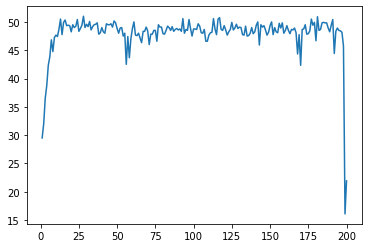

In [15]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [16]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)